In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt

## 前导知识

[1 2 3 4 5] [ 7 12 17 22 27]
5.0 2.0


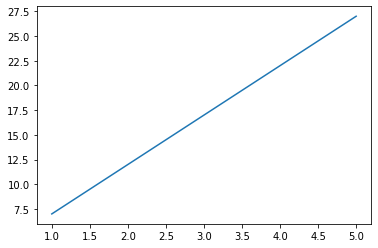

In [2]:
#我们后来讲协整会讲到最小二乘法以及线性回归
m = np.array([1,2,3,4,5])
n = m * 5 + 2
print(m,n)
slope,intercept = np.polyfit(m,n,1).round(2)    
#np.ployfit(x,y,1)  ->  最后一个参数是我们的自由度，如果是1的话那么就是线性回归，如果是2那么就是二项回归
#round(2)就是保留2为小数
plt.plot(m, n)  #这里可以看出画的图
#而线性回归是有两个返回值，第一个就是slope就是斜率，第二个就是intercept就是截距
print(slope,intercept)
plt.show()

## 1.数据准备 & 回测准备

In [3]:
data = pdr.get_data_yahoo(['JPM','GS'], start = '2018-1-1', end = '2019-7-25')['Close']
data.head()

Symbols,JPM,GS
Date,,
2018-01-02,107.949997,255.669998
2018-01-03,108.059998,253.289993
2018-01-04,109.040001,256.829987
2018-01-05,108.339996,255.520004
2018-01-08,108.500000,251.809998


Date
2018-01-02    255.669998
2018-01-03    253.289993
2018-01-04    256.829987
2018-01-05    255.520004
2018-01-08    251.809998
Name: GS, dtype: float64


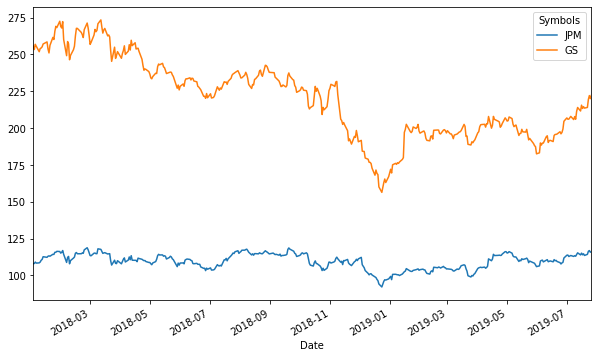

In [4]:
print(data.iloc[:,1].head())  #这相当于我们把第二列的所有行都抽出来，这里相当于是前导知识学习部分
data.plot(figsize = (10,6))
plt.show()

## 2.策略开发思路

In [5]:
data.corr()
#计算出这两只股票的方差和协方差矩阵,在这里不太会用得到，但是如果我们股票数一多起来，那么通过这个我们就可以看到各个股票之间方差和协方差之间的关系了

Symbols,JPM,GS
Symbols,,
JPM,1.000000,0.679386
GS,0.679386,1.000000


#### 而后我们要通过数据可视化来看看这两支股票的相关关系

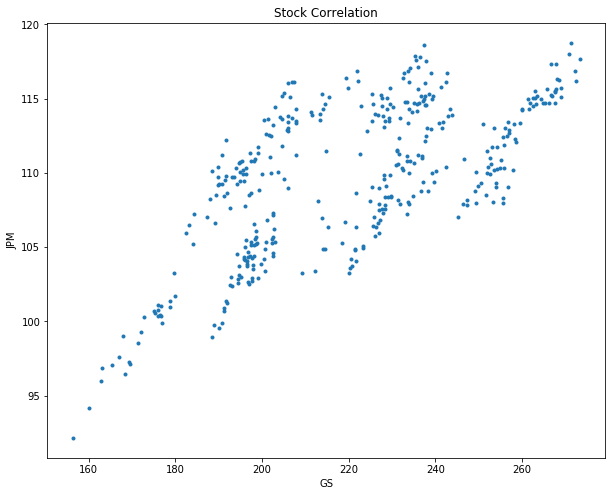

In [6]:
plt.figure(figsize = (10,8))
plt.title('Stock Correlation')
plt.plot(data['GS'],data['JPM'],'.')
plt.xlabel('GS')
plt.ylabel('JPM')
data.dropna(inplace = True)
plt.show()  #从这张图中，虽然后面有些许发散，但是整体来看还是有比较强的线性关系

### 改进版策略的核心

In [7]:
[slope,intercept] = np.polyfit(data.iloc[:,0],data.iloc[:,1],1).round(2)  #这里就是我们找到的线性组合
slope,intercept#这里就相当于是y = 3.56x -169.64 + ε

(3.56, -169.64)

#### 而ε = y - 3.56x + 169.64,之前我们讲过如果线性回归没有问题的话，那么ε的均值为0，方差是常数，符合正态分布的，是满足stationary的条件的
#### 既然ε为stationary，那么等式右边也就是stationary，那么当我们ε足够大或者足够小的时候，我们都认为ε会趋向于0，那么我们就可以开始套利了。
#### ε就是我们说的spread

In [8]:
data['spread'] = data.iloc[:,1] - (data.iloc[:,0] * slope + intercept)
data.head()

Symbols,JPM,GS,spread
Date,,,
2018-01-02,107.949997,255.669998,41.008009
2018-01-03,108.059998,253.289993,38.236402
2018-01-04,109.040001,256.829987,38.287583
2018-01-05,108.339996,255.520004,39.469617
2018-01-08,108.500000,251.809998,35.189998


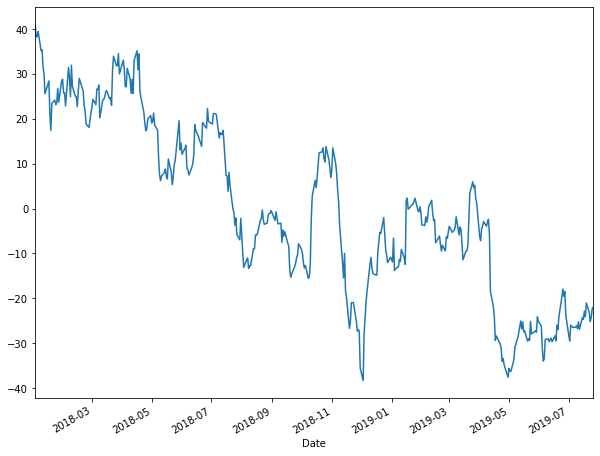

In [9]:
data['spread'].plot(figsize = (10,8))
plt.show()

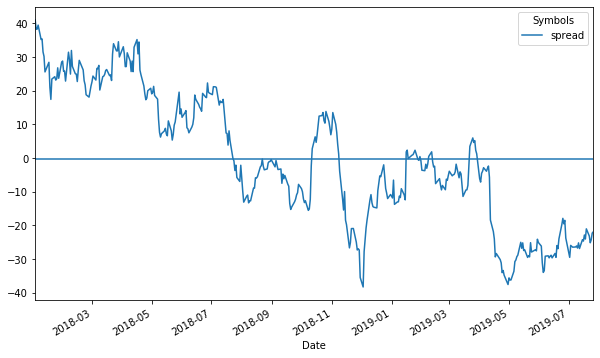

In [10]:
data[['spread']].plot(figsize = (10,6))
plt.axhline(data['spread'].mean())
plt.show()

### 接下来我们算我们的zscore

In [11]:
plt.figure()
data['zscore'] = (data['spread'] - data['spread'].mean())/data['spread'].std()   #zscore其实就是我们之前的standarization
data.head()

Symbols,JPM,GS,spread,zscore
Date,,,,
2018-01-02,107.949997,255.669998,41.008009,2.112515
2018-01-03,108.059998,253.289993,38.236402,1.971097
2018-01-04,109.040001,256.829987,38.287583,1.973708
2018-01-05,108.339996,255.520004,39.469617,2.034020
2018-01-08,108.500000,251.809998,35.189998,1.815658


<Figure size 432x288 with 0 Axes>

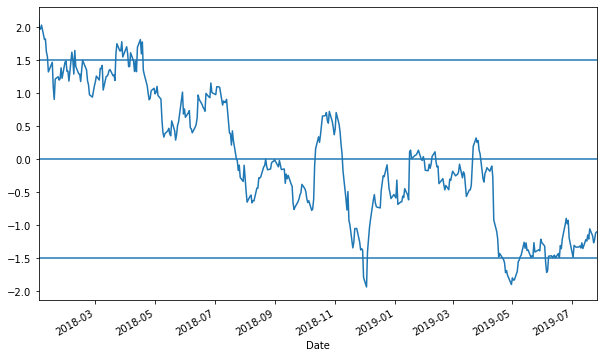

In [12]:
data['zscore'].plot(figsize = (10,6))
plt.axhline(1.5)
plt.axhline(0)
plt.axhline(-1.5)
plt.show()

### 产生交易信号

#### 这里我们注意一下，我们的X是GS，我们的Y是JPM，如果我们的ε太大超过了1.5倍标准差，说明y价格越大，也就是JPM价格越大，因为ε = y -ax - b
#### y是JPM,而x是GS，所以如果超过1.5倍标准差，说明我们要做空JPM做多GS
#### 这里要注意和我们最基础的策略虽然在同一位置，但是开仓空仓的股票是不一样的。因为我们最基础的版本相当于就是GS - JPM

In [13]:
data['position_JPM'] = np.where(data['zscore'] > 1.5, -1, np.nan)
data['position_JPM'] = np.where(data['zscore'] < -1.5, 1, data['position_JPM'])
data['position_JPM'] = np.where(abs(data['zscore']) < 0.5, 0, data['position_JPM'])
data.head(10)

Symbols,JPM,GS,spread,zscore,position_JPM
Date,,,,,
2018-01-02,107.949997,255.669998,41.008009,2.112515,-1.0
2018-01-03,108.059998,253.289993,38.236402,1.971097,-1.0
2018-01-04,109.040001,256.829987,38.287583,1.973708,-1.0
2018-01-05,108.339996,255.520004,39.469617,2.034020,-1.0
2018-01-08,108.500000,251.809998,35.189998,1.815658,-1.0
2018-01-09,109.050003,253.940002,35.361992,1.824434,-1.0
2018-01-10,110.250000,254.330002,31.480002,1.626360,-1.0
2018-01-11,110.839996,255.130005,30.179618,1.560009,-1.0
2018-01-12,112.669998,257.029999,25.564805,1.324544,NaN


Symbols            JPM          GS     spread    zscore  position_JPM  \
Date                                                                    
2018-01-02  107.949997  255.669998  41.008009  2.112515          -1.0   
2018-01-03  108.059998  253.289993  38.236402  1.971097          -1.0   
2018-01-04  109.040001  256.829987  38.287583  1.973708          -1.0   
2018-01-05  108.339996  255.520004  39.469617  2.034020          -1.0   
2018-01-08  108.500000  251.809998  35.189998  1.815658          -1.0   

Symbols     position_GS  
Date                     
2018-01-02          1.0  
2018-01-03          1.0  
2018-01-04          1.0  
2018-01-05          1.0  
2018-01-08          1.0  


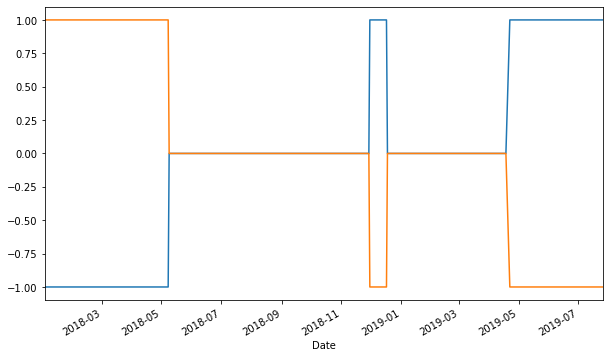

In [16]:
data['position_JPM'] = data['position_JPM'].fillna(method = 'ffill')
plt.figure()
data['position_JPM'].plot(ylim = [-1.1,1.1], figsize = (10,6))

data['position_GS'] = -np.sign(data['position_JPM'])
print(data.head())
data['position_GS'].plot(ylim = [-1.1,1.1], figsize = (10,6))
plt.show()

## 3.计算策略年化收益并可视化

In [17]:
data['return_GS'] = np.log(data['GS']/data['GS'].shift(1))
data['return_JPM'] = np.log(data['JPM']/data['JPM'].shift(1))
data.head()

Symbols,JPM,GS,spread,zscore,position_JPM,position_GS,return_GS,return_JPM
Date,,,,,,,,
2018-01-02,107.949997,255.669998,41.008009,2.112515,-1.0,1.0,NaN,NaN
2018-01-03,108.059998,253.289993,38.236402,1.971097,-1.0,1.0,-0.009352,0.001018
2018-01-04,109.040001,256.829987,38.287583,1.973708,-1.0,1.0,0.013879,0.009028
2018-01-05,108.339996,255.520004,39.469617,2.034020,-1.0,1.0,-0.005114,-0.006440
2018-01-08,108.500000,251.809998,35.189998,1.815658,-1.0,1.0,-0.014626,0.001476


#### 这里的特殊点在于我们的收益应该是两只股票同时给我们带来的

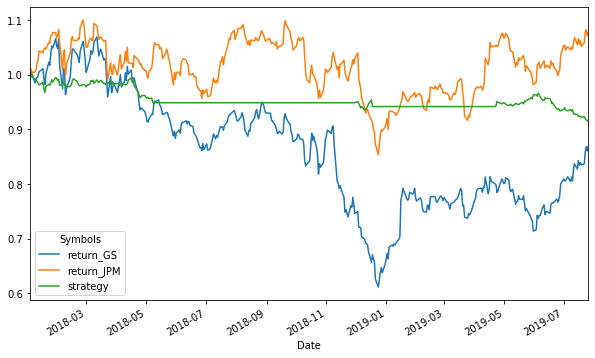

In [18]:
data['strategy'] = 0.5*(data['position_GS'].shift(1)*data['return_GS']) + 0.5*(data['position_JPM'].shift(1)*data['return_JPM'])
data[['return_GS','return_JPM','strategy']].dropna().cumsum().apply(np.exp).plot(figsize = (10,6))
plt.show()